In [220]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import *
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
Data = pd.read_csv("Car_Crash_Cleaned_AADT.csv")
AADT = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRXk2ssI2wP32cbxd7gJecku7nS9Mjim7Ed3dorQsgalcBYC6KbxpWKlx0ClBsmsgAcbf5QzQqt2tsy/pub?output=csv")
state_road_located = []
for i in Data['Associated State Road Number'].unique():
    found = 0
    for j in AADT['StateRouteNumber'].unique():
        if i == j:
            found = 1
    if found == 1:
        state_road_located.append(i)

in_set = []
for i in Data['Associated State Road Number']:
    in_set.append(i in state_road_located)

Data.insert(Data.shape[1], "SR found" , in_set)
indexD = Data[ (Data['SR found'] == False) ].index
Data.drop(indexD , inplace=True)
Data = Data.drop(['SR found'], axis=1)
Data = Data.reindex(np.arange(len(Data)))

Data

,Collision Report Number,Collision Date,County,City,Jurisdiction,Agency,Primary Trafficway,Primary Road Number,Secondary Trafficway,Secondary Road Number,...,Object Struck,Damage Threshold Met,Hit and Run,Motor Vehicles Involved,Passengers Involved,Commercial Carrier Involved,School Bus Involved,Pedestrians Involved,Pedalcyclists Involved,AADT
0,EC12134,1/1/2022 12:13:00 AM,King,Bellevue,State Road,State Patrol,WB I 90,90.0,FROM SB I-405,405.0,...,barrier,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,84000.0
1,EC09140,1/1/2022 12:26:00 AM,Kitsap,Bremerton,State Road,State Patrol,SR 3,3.0,NaN,NaN,...,Concrete/Jersey Barrier,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,80000.0
2,EC28579,1/1/2022 12:33:00 AM,Spokane,Airway Heights,State Road,Municipal/City Police,HWY 2,2.0,GARFIELD RD,NaN,...,NaN,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,5400.0
3,EC28579,1/1/2022 12:33:00 AM,Spokane,Airway Heights,State Road,Municipal/City Police,HWY 2,2.0,GARFIELD RD,NaN,...,NaN,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,5400.0
4,EC09574,1/1/2022 12:48:00 AM,Grant,Mattawa,State Road,State Patrol,SR 243,243.0,MORRISON ROAD,NaN,...,none,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,5200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43390,ED21157,12/29/2022 10:44:00 PM,Pierce,Tacoma,State Road,State Patrol,NB I-705,705.0,SCHUSTER PKWY,NaN,...,Concrete/Jersey Barrier,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,38000.0
43391,ED21157,12/29/2022 10:44:00 PM,Pierce,Tacoma,State Road,State Patrol,NB I-705,705.0,SCHUSTER PKWY,NaN,...,Concrete/Jersey Barrier,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,38000.0
43392,ED20405,12/29/2022 11:05:00 PM,Pierce,Lakewood,State Road,State Patrol,NB I-5,5.0,GRAVELLY LAKE DRIVE,NaN,...,Guardrail,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,151000.0
43393,ED20258,12/29/2022 11:07:00 PM,King,Auburn,State Road,Municipal/City Police,SR-164,164.0,6 ST SE,NaN,...,NaN,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5400.0


In [3]:
X = Data[['Associated State Road Number','Mile Post','Intersection Related', 'Weather Condition',
       'Lighting Condition',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT']]


In [4]:
values = {"Lighting Condition": 'Unkown', "Weather Condition": 'Other', 'Passengers Involved':0.0, 'Commercial Carrier Involved':0.0,
       'School Bus Involved':0.0, 'Pedestrians Involved':0.0, 'Pedalcyclists Involved':0.0}
X=X.fillna(value=values)
X=X.dropna()

In [5]:
Conditions = ['Weather Condition','Lighting Condition']
Weather_Correspondance = [2,1,0,3,4,8,6,5,7]
Lighting_Correspondance=[3,5,1,7,4,0,6,2,7]

In [6]:
for Condition in Conditions:
    use_list = []
    states = []
    if Condition == 'Weather Condition':
        use_list = Weather_Correspondance = [2,1,0,3,4,8,6,5,7]
        states = X['Weather Condition'].unique()
    else:
        use_list = Lighting_Correspondance=[3,5,2,7,4,0,6,2,7]
        states = X['Lighting Condition'].unique()
    for i in np.arange(X[Condition].unique().shape[0]):
        X.loc[X[Condition] == states[i], Condition] = use_list[i]

In [7]:
Y = Data[['Injury Severity']].iloc[X.index.to_list()]


In [8]:
def GaussianNBEval(X_values: pd.DataFrame, Y_values: pd.DataFrame) -> None:
    Observation = X_values.to_numpy()
    Results = Y_values.to_numpy().ravel()
    X_train, X_test, y_train, y_test = train_test_split(Observation, Results, test_size=0.9, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    print("Number of mislabeled points out of a total %d points : %d"
          % (X_test.shape[0], (y_test != y_pred).sum()))
    print(1 - float((y_test != y_pred).sum())/X_test.shape[0])
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred)
    
    # Print classification report
    print("\nClassification Report:")
    print(class_report)
    values_index = Y_values['Injury Severity'].unique().tolist()
    values_index.sort()
    cm_df = pd.DataFrame(conf_matrix,
                     index = values_index, 
                     columns = values_index)
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

    unique_values, counts = np.unique(y_pred, return_counts=True)
    print("Predicted values:")
    for value, count in zip(unique_values, counts):
        print(f"{value} occurs {count} times")
    unique_values, counts = np.unique(y_test, return_counts=True)
    
    print("\nActual values:")
    for value, count in zip(unique_values, counts):
        print(f"{value} occurs {count} times")

    return None

Number of mislabeled points out of a total 35487 points : 9399
0.7351424465297152
Confusion Matrix:
[[    0     0   337     0     0]
 [    0     0  7471     0     0]
 [    1     0 26088     0     0]
 [    0     0   705     0     0]
 [    0     0   885     0     0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.00      0.00      0.00       337
  Minor Injury Collision       0.00      0.00      0.00      7471
     No Injury Collision       0.74      1.00      0.85     26089
Serious Injury Collision       0.00      0.00      0.00       705
Unknown Injury Collision       0.00      0.00      0.00       885

                accuracy                           0.74     35487
               macro avg       0.15      0.20      0.17     35487
            weighted avg       0.54      0.74      0.62     35487



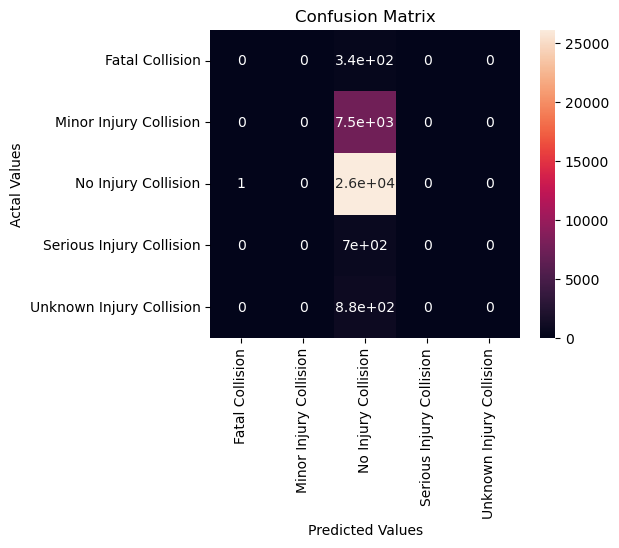

Predicted values:
Fatal Collision occurs 1 times
No Injury Collision occurs 35486 times

Actual values:
Fatal Collision occurs 337 times
Minor Injury Collision occurs 7471 times
No Injury Collision occurs 26089 times
Serious Injury Collision occurs 705 times
Unknown Injury Collision occurs 885 times


In [9]:
test = GaussianNBEval(X,Y)

Number of mislabeled points out of a total 35487 points : 25362
0.28531574942936855
Confusion Matrix:
[[   75     3   130     0   129]
 [   72    18  3326     8  4047]
 [   22     7  9175    14 16871]
 [   43    16   321     1   324]
 [    0     0    29     0   856]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.35      0.22      0.27       337
  Minor Injury Collision       0.41      0.00      0.00      7471
     No Injury Collision       0.71      0.35      0.47     26089
Serious Injury Collision       0.04      0.00      0.00       705
Unknown Injury Collision       0.04      0.97      0.07       885

                accuracy                           0.29     35487
               macro avg       0.31      0.31      0.16     35487
            weighted avg       0.61      0.29      0.35     35487



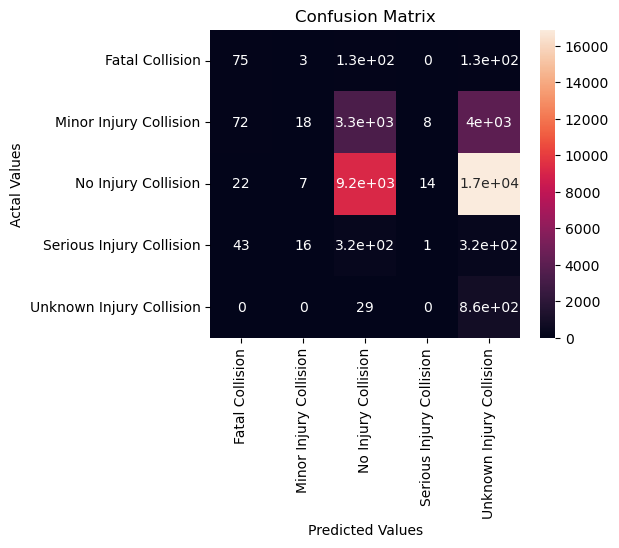

Predicted values:
Fatal Collision occurs 212 times
Minor Injury Collision occurs 44 times
No Injury Collision occurs 12981 times
Serious Injury Collision occurs 23 times
Unknown Injury Collision occurs 22227 times

Actual values:
Fatal Collision occurs 337 times
Minor Injury Collision occurs 7471 times
No Injury Collision occurs 26089 times
Serious Injury Collision occurs 705 times
Unknown Injury Collision occurs 885 times


In [10]:
test = GaussianNBEval(X.drop(['AADT'],axis = 1),Y)

In [11]:
Injury_Data = Data[Data["Injury Severity"] != "No Injury Collision"]
Known_Injury_Data = Data[(Data["Injury Severity"] != "No Injury Collision") & (Data["Injury Severity"] != "Unknown Injury Collision")]
Bad_Injury_Data = Data[(Data["Injury Severity"] != "No Injury Collision") & (Data["Injury Severity"] != "Unknown Injury Collision")& (Data["Injury Severity"] != "Minor Injury Collision")]

In [12]:
iX = Injury_Data[['Associated State Road Number','Mile Post','Intersection Related', 'Weather Condition',
       'Lighting Condition',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT']]
iX=iX.fillna(value=values)
iX=iX.dropna()

In [13]:
for Condition in Conditions:
    use_list = []
    states = []
    if Condition == 'Weather Condition':
        use_list = Weather_Correspondance = [2,1,0,3,4,8,6,5,7]
        states = iX['Weather Condition'].unique()
    else:
        use_list = Lighting_Correspondance=[3,5,2,7,4,0,6,2,7]
        states = iX['Lighting Condition'].unique()
    for i in np.arange(iX[Condition].unique().shape[0]):
        iX.loc[iX[Condition] == states[i], Condition] = use_list[i]

In [14]:
iY =  Data[['Injury Severity']].iloc[iX.index.to_list()]

Number of mislabeled points out of a total 9395 points : 1910
0.7967003725385844
Confusion Matrix:
[[   0  329    0    0]
 [   0 7485    0    0]
 [   0  698    0    0]
 [   0  883    0    0]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.00      0.00      0.00       329
  Minor Injury Collision       0.80      1.00      0.89      7485
Serious Injury Collision       0.00      0.00      0.00       698
Unknown Injury Collision       0.00      0.00      0.00       883

                accuracy                           0.80      9395
               macro avg       0.20      0.25      0.22      9395
            weighted avg       0.63      0.80      0.71      9395



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


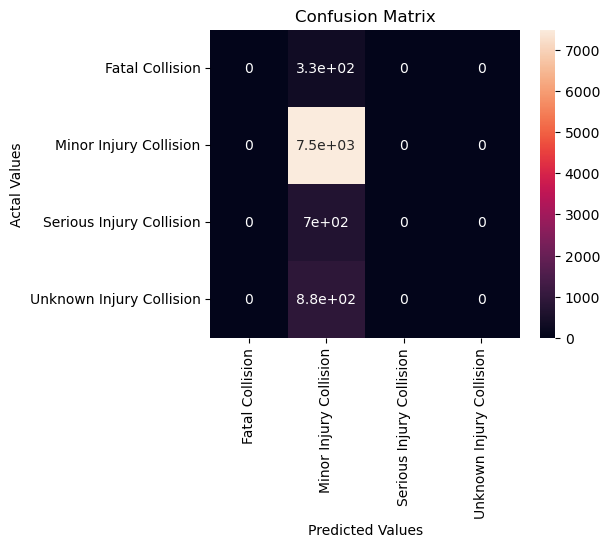

Predicted values:
Minor Injury Collision occurs 9395 times

Actual values:
Fatal Collision occurs 329 times
Minor Injury Collision occurs 7485 times
Serious Injury Collision occurs 698 times
Unknown Injury Collision occurs 883 times


In [15]:
GaussianNBEval(iX,iY)

Number of mislabeled points out of a total 9395 points : 4906
0.4778073443320915
Confusion Matrix:
[[  69  143    3  114]
 [ 113 3577   20 3775]
 [  51  354   11  282]
 [   0   51    0  832]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.30      0.21      0.25       329
  Minor Injury Collision       0.87      0.48      0.62      7485
Serious Injury Collision       0.32      0.02      0.03       698
Unknown Injury Collision       0.17      0.94      0.28       883

                accuracy                           0.48      9395
               macro avg       0.41      0.41      0.29      9395
            weighted avg       0.74      0.48      0.53      9395



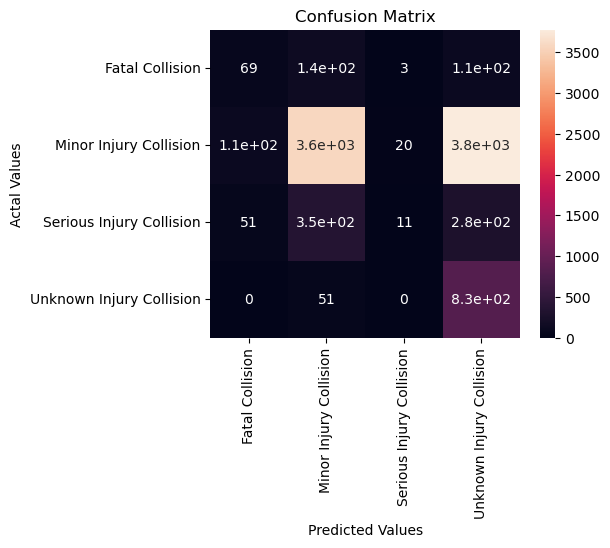

Predicted values:
Fatal Collision occurs 233 times
Minor Injury Collision occurs 4125 times
Serious Injury Collision occurs 34 times
Unknown Injury Collision occurs 5003 times

Actual values:
Fatal Collision occurs 329 times
Minor Injury Collision occurs 7485 times
Serious Injury Collision occurs 698 times
Unknown Injury Collision occurs 883 times


In [16]:
GaussianNBEval(iX.drop(['AADT'],axis = 1),iY)

Number of mislabeled points out of a total 9395 points : 1910
0.7967003725385844
Confusion Matrix:
[[   0  329    0    0]
 [   0 7485    0    0]
 [   0  698    0    0]
 [   0  883    0    0]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.00      0.00      0.00       329
  Minor Injury Collision       0.80      1.00      0.89      7485
Serious Injury Collision       0.00      0.00      0.00       698
Unknown Injury Collision       0.00      0.00      0.00       883

                accuracy                           0.80      9395
               macro avg       0.20      0.25      0.22      9395
            weighted avg       0.63      0.80      0.71      9395



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


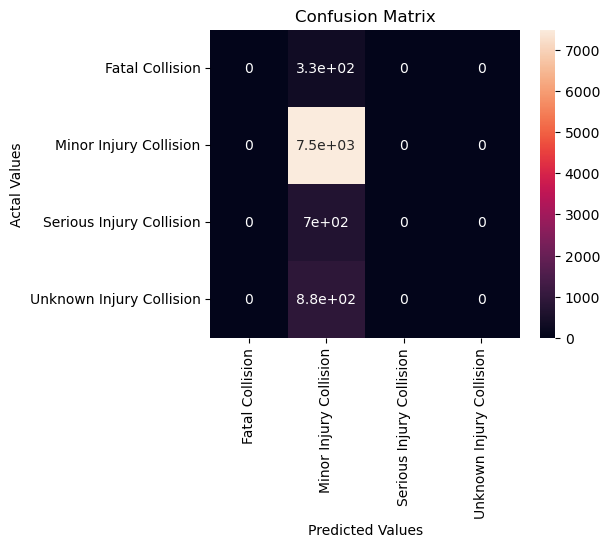

Predicted values:
Minor Injury Collision occurs 9395 times

Actual values:
Fatal Collision occurs 329 times
Minor Injury Collision occurs 7485 times
Serious Injury Collision occurs 698 times
Unknown Injury Collision occurs 883 times


In [17]:
GaussianNBEval(iX,iY)

In [18]:
kiX = Known_Injury_Data[['Associated State Road Number','Mile Post','Intersection Related', 'Weather Condition',
       'Lighting Condition',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT']]
kiX=kiX.fillna(value=values)
kiX=kiX.dropna()

In [19]:
for Condition in Conditions:
    use_list = []
    states = []
    if Condition == 'Weather Condition':
        use_list = Weather_Correspondance = [2,1,0,3,4,8,6,5,7]
        states = kiX['Weather Condition'].unique()
    else:
        use_list = Lighting_Correspondance=[3,5,2,7,4,0,6,2,7]
        states = kiX['Lighting Condition'].unique()
    for i in np.arange(kiX[Condition].unique().shape[0]):
        kiX.loc[kiX[Condition] == states[i], Condition] = use_list[i]

In [20]:
kiY =  Data[['Injury Severity']].iloc[kiX.index.to_list()]

Number of mislabeled points out of a total 8510 points : 1103
0.8703877790834312
Confusion Matrix:
[[   3  338    0]
 [  71 7404    0]
 [  10  684    0]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.04      0.01      0.01       341
  Minor Injury Collision       0.88      0.99      0.93      7475
Serious Injury Collision       0.00      0.00      0.00       694

                accuracy                           0.87      8510
               macro avg       0.30      0.33      0.32      8510
            weighted avg       0.77      0.87      0.82      8510



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


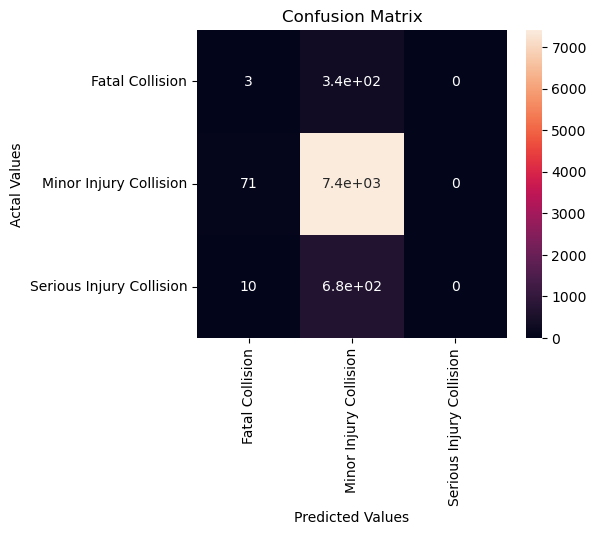

Predicted values:
Fatal Collision occurs 84 times
Minor Injury Collision occurs 8426 times

Actual values:
Fatal Collision occurs 341 times
Minor Injury Collision occurs 7475 times
Serious Injury Collision occurs 694 times


In [21]:
GaussianNBEval(kiX,kiY)

Number of mislabeled points out of a total 8510 points : 1747
0.7947121034077556
Confusion Matrix:
[[ 129  209    3]
 [ 842 6619   14]
 [ 125  554   15]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.12      0.38      0.18       341
  Minor Injury Collision       0.90      0.89      0.89      7475
Serious Injury Collision       0.47      0.02      0.04       694

                accuracy                           0.79      8510
               macro avg       0.49      0.43      0.37      8510
            weighted avg       0.83      0.79      0.79      8510



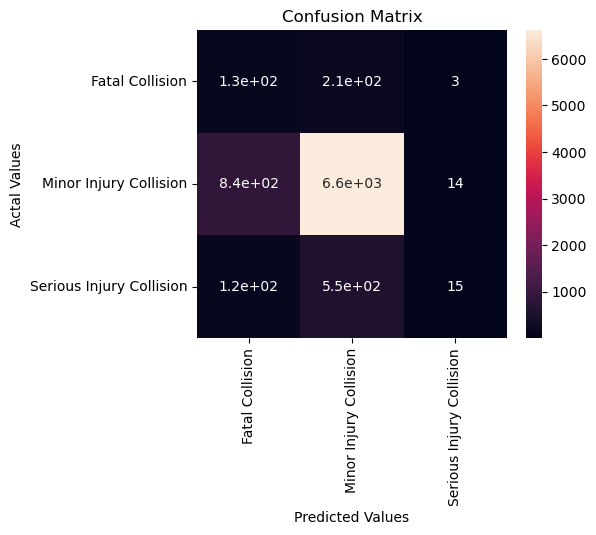

Predicted values:
Fatal Collision occurs 1096 times
Minor Injury Collision occurs 7382 times
Serious Injury Collision occurs 32 times

Actual values:
Fatal Collision occurs 341 times
Minor Injury Collision occurs 7475 times
Serious Injury Collision occurs 694 times


In [22]:
GaussianNBEval(kiX.drop(['AADT'],axis = 1),kiY)

In [23]:
biX = Bad_Injury_Data[['Associated State Road Number','Mile Post','Intersection Related', 'Weather Condition',
       'Lighting Condition',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT']]
biX=biX.fillna(value=values)
biX=biX.dropna()

In [24]:
biX['Weather Condition'].unique()

array(['Clear', 'Snowing', 'Fog or Smog or Smoke', 'Overcast',
       'Sleet or Hail or Freezing Rain', 'Raining', 'Other'], dtype=object)

In [25]:
for Condition in Conditions:
    use_list = []
    states = []
    if Condition == 'Weather Condition':
        use_list = Weather_Correspondance = [0,3,5,1,4,2,6]
        states = biX['Weather Condition'].unique()
    else:
        use_list = Lighting_Correspondance=[3,5,2,7,4,0,6,2,7]
        states = biX['Lighting Condition'].unique()
    for i in np.arange(biX[Condition].unique().shape[0]):
        biX.loc[biX[Condition] == states[i], Condition] = use_list[i]

In [26]:
biY =  Data[['Injury Severity']].iloc[biX.index.to_list()]

Number of mislabeled points out of a total 1037 points : 403
0.6113789778206364
Confusion Matrix:
[[ 54 275]
 [128 580]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.30      0.16      0.21       329
Serious Injury Collision       0.68      0.82      0.74       708

                accuracy                           0.61      1037
               macro avg       0.49      0.49      0.48      1037
            weighted avg       0.56      0.61      0.57      1037



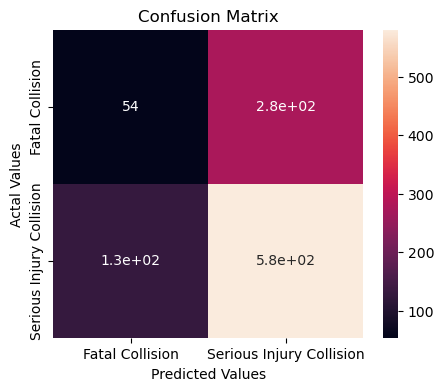

Predicted values:
Fatal Collision occurs 182 times
Serious Injury Collision occurs 855 times

Actual values:
Fatal Collision occurs 329 times
Serious Injury Collision occurs 708 times


In [27]:
GaussianNBEval(biX,biY)

Number of mislabeled points out of a total 1037 points : 317
0.6943105110896818
Confusion Matrix:
[[ 72 257]
 [ 60 648]]

Classification Report:
                          precision    recall  f1-score   support

         Fatal Collision       0.55      0.22      0.31       329
Serious Injury Collision       0.72      0.92      0.80       708

                accuracy                           0.69      1037
               macro avg       0.63      0.57      0.56      1037
            weighted avg       0.66      0.69      0.65      1037



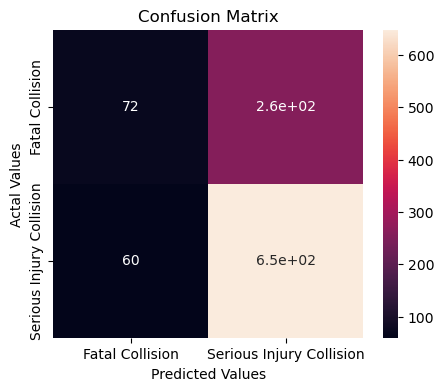

Predicted values:
Fatal Collision occurs 132 times
Serious Injury Collision occurs 905 times

Actual values:
Fatal Collision occurs 329 times
Serious Injury Collision occurs 708 times


In [28]:
GaussianNBEval(biX.drop(['AADT'],axis = 1),biY)

In [53]:
len(Data['County'].unique())

39

In [88]:
pd.get_dummies(Data["Lighting Condition"], dtype=float)

,Dark - Unknown Lighting,Dark-No Street Lights,Dark-Street Lights Off,Dark-Street Lights On,Dawn,Daylight,Dusk,Other,Unknown
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
43390,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43391,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43392,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43393,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
RData = Data[Data['County'].notna() & Data['Weather Condition'].notna() & Data['Lighting Condition'].notna()]
RData = RData.join(pd.get_dummies(RData[['County','Weather Condition','Lighting Condition']], dtype=float)).drop(
    ['County_King','Weather Condition_Other','Lighting Condition_Unknown'], axis=1)
RData = RData[RData["Injury Severity"] != "Unknown Injury Collision"]

In [223]:
#Distincting level of injury
RData = RData.replace({'Injury Severity': {"No Injury Collision": 0, 
                                   'Minor Injury Collision': 1,
                                  "Serious Injury Collision": 2, 
                                   'Fatal Collision': 3}})

In [224]:
RX = RData[['Injury Severity','Associated State Road Number', 'Mile Post',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]

In [225]:
RX = RX.dropna()

In [226]:
RY = RX['Injury Severity']
RX = RX[['Associated State Road Number', 'Mile Post',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]

In [227]:
X_model = sm.add_constant(RX)
model = sm.OLS(RY, X_model)
results = model.fit()

In [228]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Injury Severity   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     51.05
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        15:17:49   Log-Likelihood:                -30015.
No. Observations:               38446   AIC:                         6.016e+04
Df Residuals:                   38381   BIC:                         6.072e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [221]:
#Just finding between Injury or not
RData = RData.replace({'Injury Severity': {"No Injury Collision": 0, 
                                   'Minor Injury Collision': 1,
                                  "Serious Injury Collision": 1, 
                                   'Fatal Collision': 1}})

RX = RData[['Injury Severity','Associated State Road Number', 'Mile Post',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]
RX = RX.dropna()
RY = RX['Injury Severity']
RX = RX[['Associated State Road Number', 'Mile Post',
       'School Zone', 'Intersection Related', 
       'Motor Vehicles Involved',
       'Passengers Involved', 'Commercial Carrier Involved',
       'School Bus Involved', 'Pedestrians Involved', 'Pedalcyclists Involved',
       'AADT', 'County_Adams', 'County_Asotin', 'County_Benton',
       'County_Chelan', 'County_Clallam', 'County_Clark', 'County_Columbia',
       'County_Cowlitz', 'County_Douglas', 'County_Ferry', 'County_Franklin',
       'County_Garfield', 'County_Grant', 'County_Grays Harbor',
       'County_Island', 'County_Jefferson', 'County_Kitsap', 'County_Kittitas',
       'County_Klickitat', 'County_Lewis', 'County_Lincoln', 'County_Mason',
       'County_Okanogan', 'County_Pacific', 'County_Pend Oreille',
       'County_Pierce', 'County_Skagit', 'County_Skamania', 'County_Snohomish',
       'County_Spokane', 'County_Stevens', 'County_Thurston',
       'County_Wahkiakum', 'County_Walla Walla', 'County_Whatcom',
       'County_Whitman', 'County_Yakima',
       'Weather Condition_Blowing Sand or Dirt or Snow',
       'Weather Condition_Clear', 'Weather Condition_Fog or Smog or Smoke',
       'Weather Condition_Overcast', 'Weather Condition_Partly Cloudy',
       'Weather Condition_Raining', 'Weather Condition_Severe Crosswind',
       'Weather Condition_Sleet or Hail or Freezing Rain',
       'Weather Condition_Snowing',
       'Lighting Condition_Dark - Unknown Lighting',
       'Lighting Condition_Dark-No Street Lights',
       'Lighting Condition_Dark-Street Lights Off',
       'Lighting Condition_Dark-Street Lights On', 'Lighting Condition_Dawn',
       'Lighting Condition_Daylight', 'Lighting Condition_Dusk',
       'Lighting Condition_Other']]
X_model = sm.add_constant(RX)
model = sm.OLS(RY, X_model)
results = model.fit()

In [222]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Injury Severity   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     51.05
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        15:17:20   Log-Likelihood:                -30015.
No. Observations:               38446   AIC:                         6.016e+04
Df Residuals:                   38381   BIC:                         6.072e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------